In [18]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
def preprocess_data(df):
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['year'] = df['release_date'].dt.year.fillna(0).astype(int)
    df['genres'] = df['genres'].apply(literal_eval)
    df['genres'] = df['genres'].apply(lambda x: [genre['name'].lower() for genre in x] if isinstance(x, list) else [])
    return df

def filter_movies(df, genre, min_runtime, max_runtime, min_year, max_year, min_vote_count):
    filtered_df = df[(df['genres'].apply(lambda x: genre in x)) & 
                     (df['runtime'].between(min_runtime, max_runtime)) & 
                     (df['year'].between(min_year, max_year)) & 
                     (df['vote_count'] >= min_vote_count)]
    return filtered_df

def calculate_weighted_rating(df):
    df_copy = df.copy()
    m = df_copy['vote_count'].quantile(0.80)
    C = df_copy['vote_average'].mean()
    df_copy['weighted_rating'] = (df_copy['vote_count'] / (df_copy['vote_count'] + m) * df_copy['vote_average']) + (m / (m + df_copy['vote_count']) * C)
    return df_copy

def recommend_similar_movies(title_input, df, see_top=10):
    indices = pd.Series(df.index, index=df['title'])
    try:
        idx = indices[title_input]
    except KeyError:
        print(f"Movie '{title_input}' not found. Please enter a valid movie title.")
        return
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['overview'].fillna(''))
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:see_top+1]
    movie_indices = [i[0] for i in sim_scores]
    return df.iloc[movie_indices]['title']


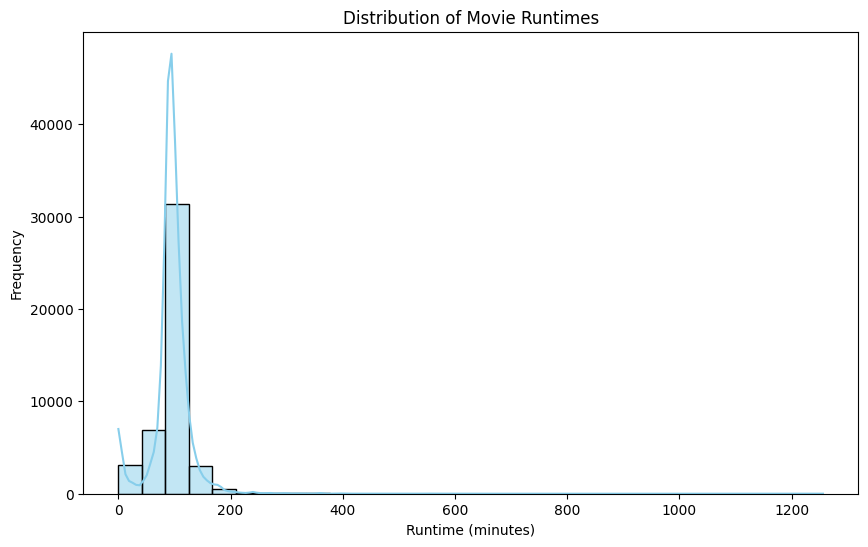

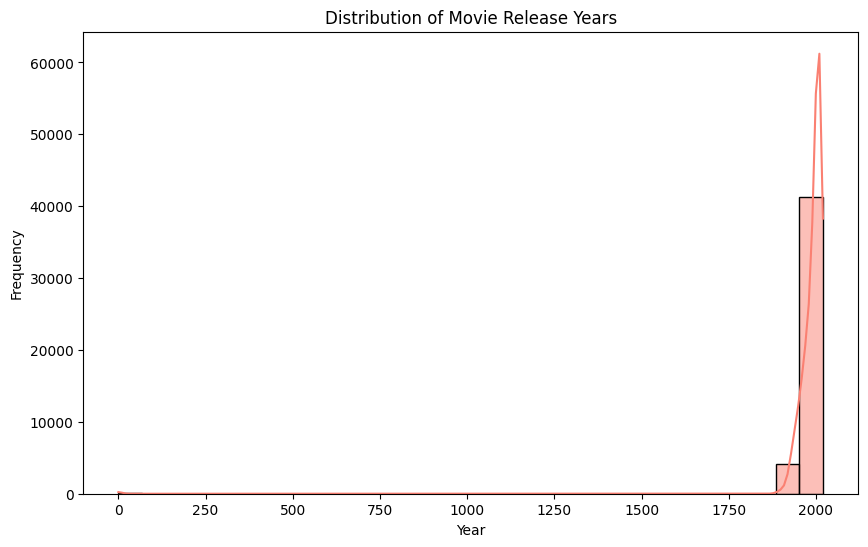

In [20]:
# Load dataset
database_path = r'C:\Users\ASUS\OneDrive\Desktop\All Work\movies_metadata.csv'
df = pd.read_csv(database_path, low_memory=True, dtype={'popularity': float}, na_values=['Beware Of Frost Bites'])
# Preprocess data
df = preprocess_data(df)

# Visualize distribution of movie runtimes
plt.figure(figsize=(10, 6))
sns.histplot(df['runtime'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Distribution of Movie Runtimes')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.show()

# Visualize distribution of movie release years
plt.figure(figsize=(10, 6))
sns.histplot(df['year'].dropna(), bins=30, kde=True, color='salmon')
plt.title('Distribution of Movie Release Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

In [21]:
movie_title = input("Enter the title of the movie: ")
genre_from_title = df[df['title'] == movie_title]['genres'].iloc[0][0].lower()

# Filter movies
filtered_df = filter_movies(df, genre=genre_from_title, min_runtime=0, max_runtime=np.inf, min_year=0, max_year=np.inf, min_vote_count=0)
filtered_df = calculate_weighted_rating(filtered_df)

recommended_movies = recommend_similar_movies(title_input=movie_title, df=filtered_df)
print(recommended_movies)

Enter the title of the movie:  The Lion King


29701                       The Key to Paradise
5223                                  Iron Will
25044                           Song of the Sea
2052                      The NeverEnding Story
1065                 E.T. the Extra-Terrestrial
23437                                Maleficent
5255           Spirit: Stallion of the Cimarron
26857                            Snow in August
32883                                 The Lorax
30819    Scooby-Doo! and the Reluctant Werewolf
Name: title, dtype: object
